In [1]:
%matplotlib inline
'''
How to Train Your Dragon: V5
Sequentially optimize an already initialized FT reactive distillation process

Capability includes:

Temperature, Reflux, Product Flow Rate, Feed Allocation, Catalyst Allocation and Tray Optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-13 04:46:23 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'pf')
select_MPCC(model.reboiler,'pf')

> Selected MPCC: reactive[1].MPCC_P_pf
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_pf
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_pf
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_pf
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_pf
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_pf
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_pf
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_pf
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_pf
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_pf
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_pf
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_pf
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_pf
s_L:  1.97995836015

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=10,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)

for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
        model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
#     return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
#             sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
#     return (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total) \
#             == (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma)
    return pe.log(model.scale_epi + (model.P_tray[j,p] - model.epi) * sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total))\
            == pe.log(model.scale_epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma))            
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = True)

In [16]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
option_file_name=./ipopt.opt
linear_solver=ma86
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma97                  yes
                   linear_system_scaling = none                  yes
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start_reuse        yes
                            ma97_switch2 = od_hd_reuse           yes
                                  ma97_u = 0.01                  yes
                               ma97_umax = 0.5                   yes
                                max_iter = 500                   yes
     

In [17]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0274          0.6481  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.8  0.000       0.000  0.000  0.000  0.000       5.7751  0.0000  0.7526  0.0000       20.000
NON--[2]     132.0  0.000       0.000  0.000  0.000  0.000       5.8796  0.0000  0.6828  0.0000       20.000
NON--[3]     141.4  0.000       0.000  0.000  0.000  0.000       5.8098  0.0000  0.6177  0.0023       20.000
NON--[4]     150.0  0.000       0.000  0.000  0.000  

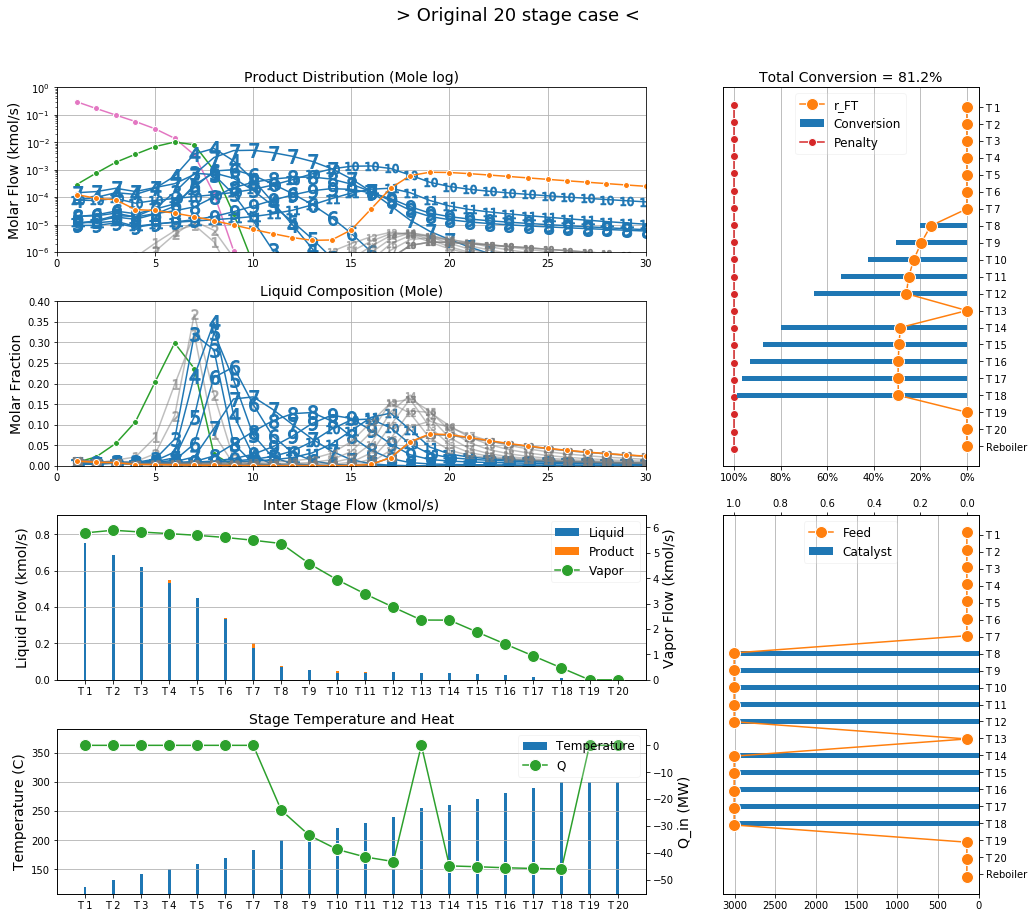

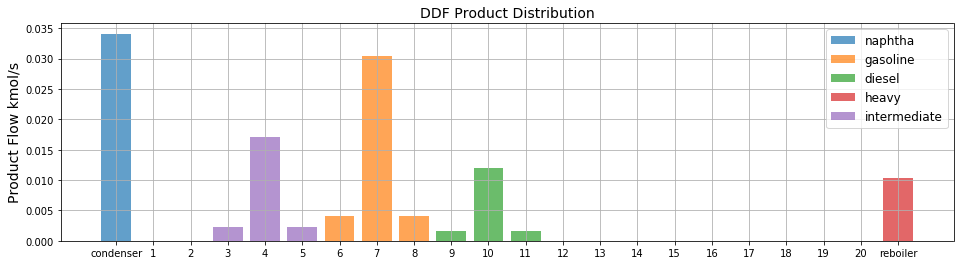

In [18]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [19]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [20]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [21]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline] - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [22]:
iter_count = 0
total_iter = 0
meta_results = {}
for i in model.component_data_objects(pe.Var,active=True):
    if i.name.count('.') <= 1:
        meta_results[i.name] = []
meta_results['iter_count'] = []
meta_results['total_iter'] = []

In [23]:
while True:
    iter_count += 2
    total_iter += 2
    opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = True)
    model_tmp = deepcopy(model)
    results = opt.solve(model_tmp,tee=False)

    for i in meta_results.keys():
        if i != 'iter_count' and i != 'total_iter':
            meta_results[i].append(model.find_component(i).value)
    meta_results['iter_count'].append(iter_count)
    meta_results['total_iter'].append(total_iter)
    
    print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
    if results.solver.termination_condition.key == 'optimal':
        break
        
iter_count = 0
model = deepcopy(model_tmp)

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 2 total_iter 2 obj 0.03897305682565123
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 4 total_iter 4 obj 0.047987706691835066
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 6 total_iter 6 obj 0.04974531057537282
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 8 total_iter 8 obj 0.05337796098611845
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 10 total_iter 10 obj 0.053394805107278884
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        

iter_count 68 total_iter 68 obj 0.10219634773588868
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 70 total_iter 70 obj 0.1001146908449058
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 72 total_iter 72 obj 0.10070929036613246
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 74 total_iter 74 obj 0.10227096500178941
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 76 total_iter 76 obj 0.09918926228039848
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 78 total_iter 78 obj 0.10223973416751249
    model=reactive_distillation;
        message from solve


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 85.61%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -148.                                        2.3194          0.6904  0.0919       2.3167

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     123.8  0.000       0.000  0.000  0.000  0.000       5.4186  0.0000  0.8147  0.0000       20.000
NON--[2]     134.8  0.000       0.000  0.000  0.000  0.000       5.5429  0.0000  0.7570  0.0000       20.000
NON--[3]     143.0  0.000       0.000  0.000  0.000  0.000       5.4853  0.0000  0.7126  0.0000       20.000
NON--[4]     150.1  0.00

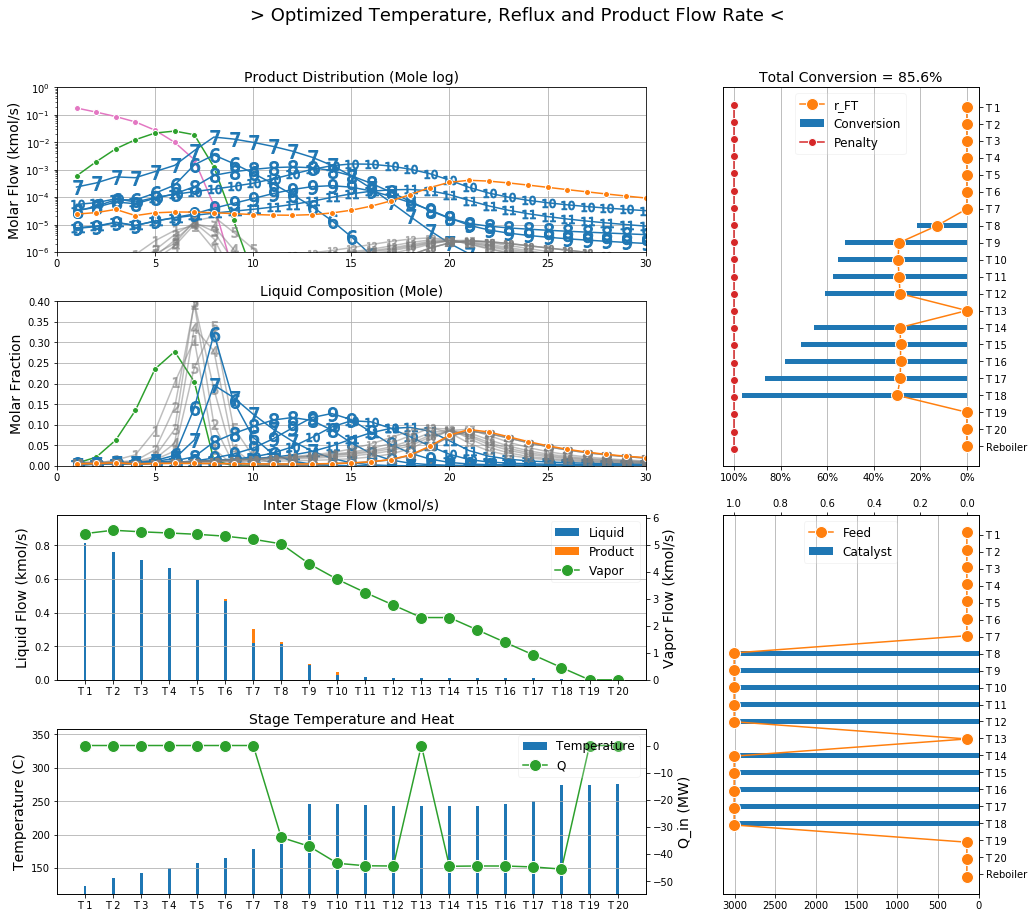

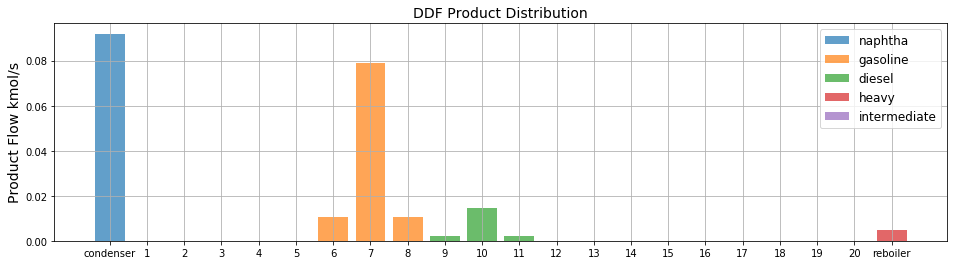

In [24]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Open up feed allocation

In [25]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [26]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)
    
# soft constraints to guide the feed allocation pattern
model.reactive[17].F.setlb(3)

In [27]:
while True:
    iter_count += 2
    total_iter += 2
    opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = True)
    model_tmp = deepcopy(model)
    results = opt.solve(model_tmp,tee=False)

    for i in meta_results.keys():
        if i != 'iter_count' and i != 'total_iter':
            meta_results[i].append(model.find_component(i).value)
    meta_results['iter_count'].append(iter_count)
    meta_results['total_iter'].append(total_iter)
    
    print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
    if results.solver.termination_condition.key == 'optimal':
        break
        
iter_count = 0
model = deepcopy(model_tmp)

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 2 total_iter 86 obj 0.10032787661760421
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 4 total_iter 88 obj 0.10032662194009573
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 6 total_iter 90 obj 0.10051956951272403
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 8 total_iter 92 obj 0.10226456558048277
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 10 total_iter 94 obj 0.10604093866001492
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
      

iter_count 68 total_iter 152 obj 0.11953165621269592
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 70 total_iter 154 obj 0.11954284203852897
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 72 total_iter 156 obj 0.1195466984546464
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 74 total_iter 158 obj 0.11975207329981497
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 76 total_iter 160 obj 0.11999591878353477
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 78 total_iter 162 obj 0.12019906633475091
    model=reactive_distillation;
        message from


> Optimized Feed Allocation
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.50%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -149.                                        1.8411          0.6318  0.0962       2.4205

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     125.4  0.000       0.000  0.000  0.000  0.000       4.9897  0.0000  0.7452  0.0000       20.000
NON--[2]     135.1  0.000       0.000  0.000  0.000  0.000       5.1031  0.0000  0.6909  0.0000       20.000
NON--[3]     142.8  0.000       0.000  0.000  0.000  0.000       5.0488  0.0000  0.6504  0.0000       20.000
NON--[4]     149.8  0.000       0.000  0.000  0.00

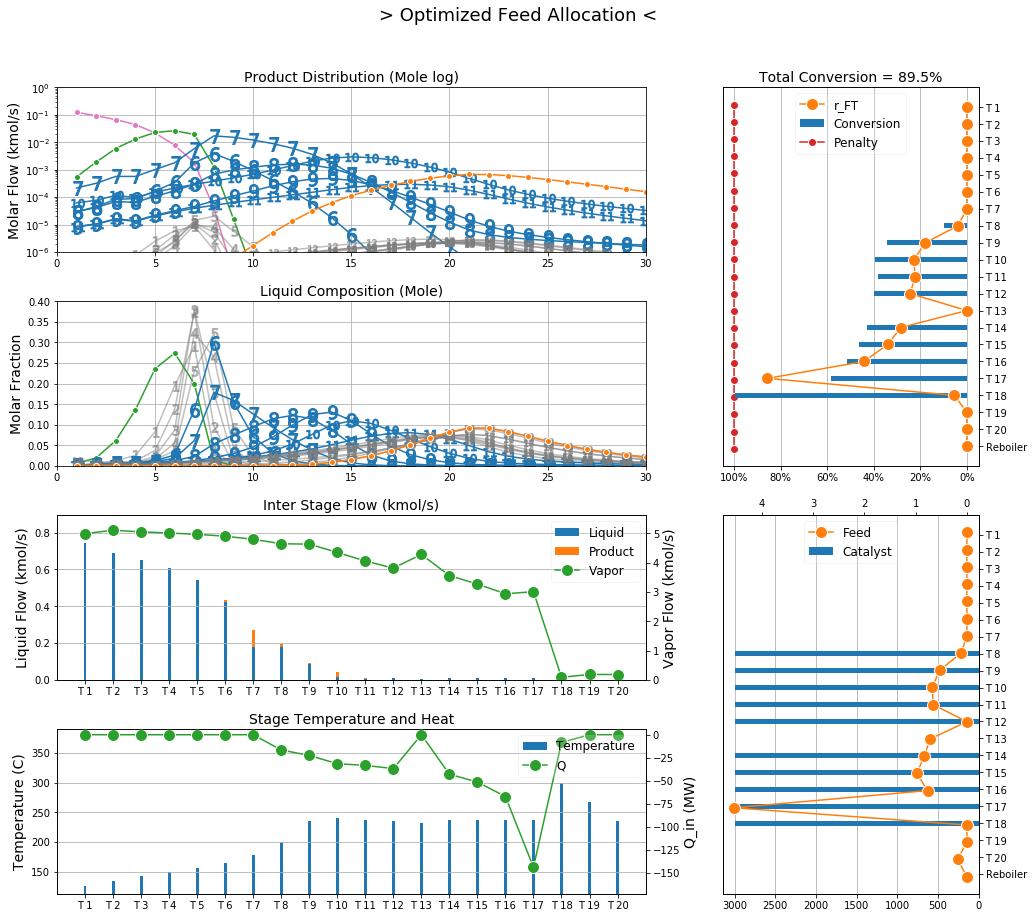

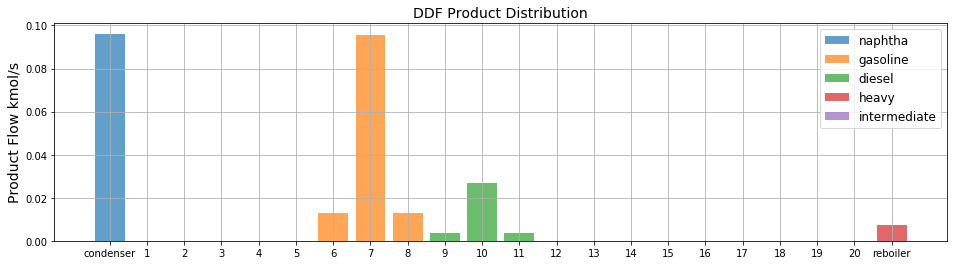

In [28]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Allocation')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Feed Allocation')
plot_product_distribution(model,pdf)

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [29]:
for j in model.TRAY_reactive:
    model.reactive[j].cat.unfix()
    model.reactive[j].cat.setlb(10)
    model.reactive[j].cat.setub(30000)

In [30]:
model.total_cat_con = pe.ConstraintList()
model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [31]:
while True:
    iter_count += 2
    total_iter += 2
    opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = True)
    model_tmp = deepcopy(model)
    results = opt.solve(model_tmp,tee=False)

    for i in meta_results.keys():
        if i != 'iter_count' and i != 'total_iter':
            meta_results[i].append(model.find_component(i).value)
    meta_results['iter_count'].append(iter_count)
    meta_results['total_iter'].append(total_iter)
    
    print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
    if results.solver.termination_condition.key == 'optimal':
        break
        
iter_count = 0
model = deepcopy(model_tmp)

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 2 total_iter 220 obj 0.12160241352379127
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 4 total_iter 222 obj 0.12160063476311606
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 6 total_iter 224 obj 0.1215932068561888
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 8 total_iter 226 obj 0.12155795819888529
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 10 total_iter 228 obj 0.12163684777588599
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
  

iter_count 68 total_iter 286 obj 0.12764968207676272
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 70 total_iter 288 obj 0.12779557514827297
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 72 total_iter 290 obj 0.12796231532909763
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 74 total_iter 292 obj 0.12800190951581356
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 76 total_iter 294 obj 0.12821521717742695
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 78 total_iter 296 obj 0.12821800725496255
    model=reactive_distillation;
        message fro


> Optimized Catalyst Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 90.04%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -151.                                        1.7220          0.6137  0.0980       2.4710

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     125.8  0.000       0.000  0.000  0.000  0.000       4.9047  0.0000  0.7246  0.0000       20.000
NON--[2]     135.2  0.000       0.000  0.000  0.000  0.000       5.0157  0.0000  0.6709  0.0000       20.000
NON--[3]     142.8  0.000       0.000  0.000  0.000  0.000       4.9620  0.0000  0.6311  0.0000       20.000
NON--[4]     149.7  0.000       0.000

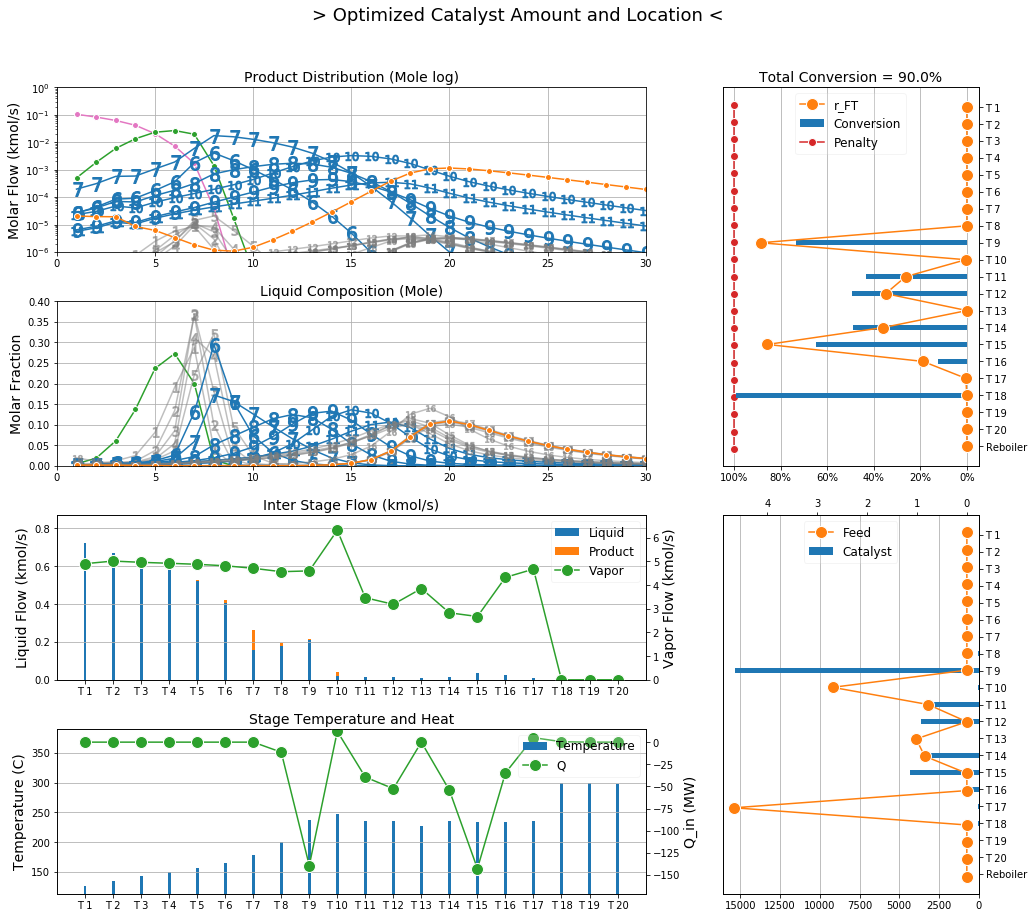

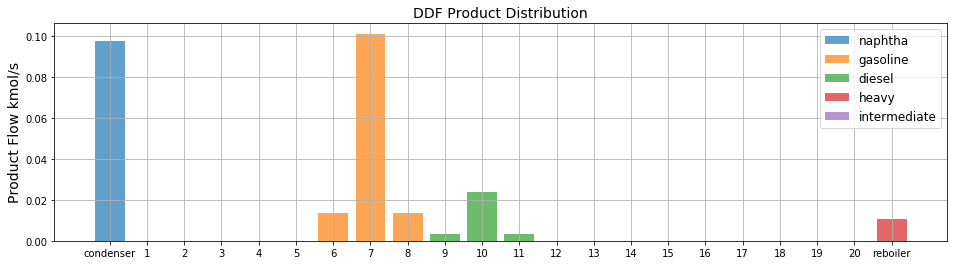

In [32]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Catalyst Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')
plot_product_distribution(model,pdf)

# Use DDF,  open up gasoline location

In [33]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [34]:
while True:
    iter_count += 2
    total_iter += 2
    opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = True)
    model_tmp = deepcopy(model)
    results = opt.solve(model_tmp,tee=False)

    for i in meta_results.keys():
        if i != 'iter_count' and i != 'total_iter':
            meta_results[i].append(model.find_component(i).value)
    meta_results['iter_count'].append(iter_count)
    meta_results['total_iter'].append(total_iter)
    
    print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
    if results.solver.termination_condition.key == 'optimal':
        break
        
iter_count = 0
model = deepcopy(model_tmp)

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 2 total_iter 336 obj 0.12902152729074692
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 4 total_iter 338 obj 0.1291777927874131
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 6 total_iter 340 obj 0.12952379748733045
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 8 total_iter 342 obj 0.12952473589468516
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 10 total_iter 344 obj 0.1294979569121765
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
   

iter_count 68 total_iter 402 obj 0.13016633316311568
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 70 total_iter 404 obj 0.13016831174031682
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 72 total_iter 406 obj 0.1301677286970428
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 74 total_iter 408 obj 0.13016747375572674
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 76 total_iter 410 obj 0.13084612326682718
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 78 total_iter 412 obj 0.13091811072914172
    model=reactive_distillation;
        message from


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.71%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -147.                                        1.7678          0.5619  0.0922       2.4486

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     123.1  0.000       0.000  0.000  0.000  0.000       4.8706  0.0000  0.6511  0.0000       20.000
NON--[2]     131.7  0.000       0.000  0.000  0.000  0.000       4.9599  0.0000  0.5929  0.0000       20.000
NON--[3]     139.5  0.000       0.000  0.000  0.000  0.000       4.9016  0.0000  0.5434  0.0000       20.000
NON--[4]     147.5  0.000       0.000  0.000  0.

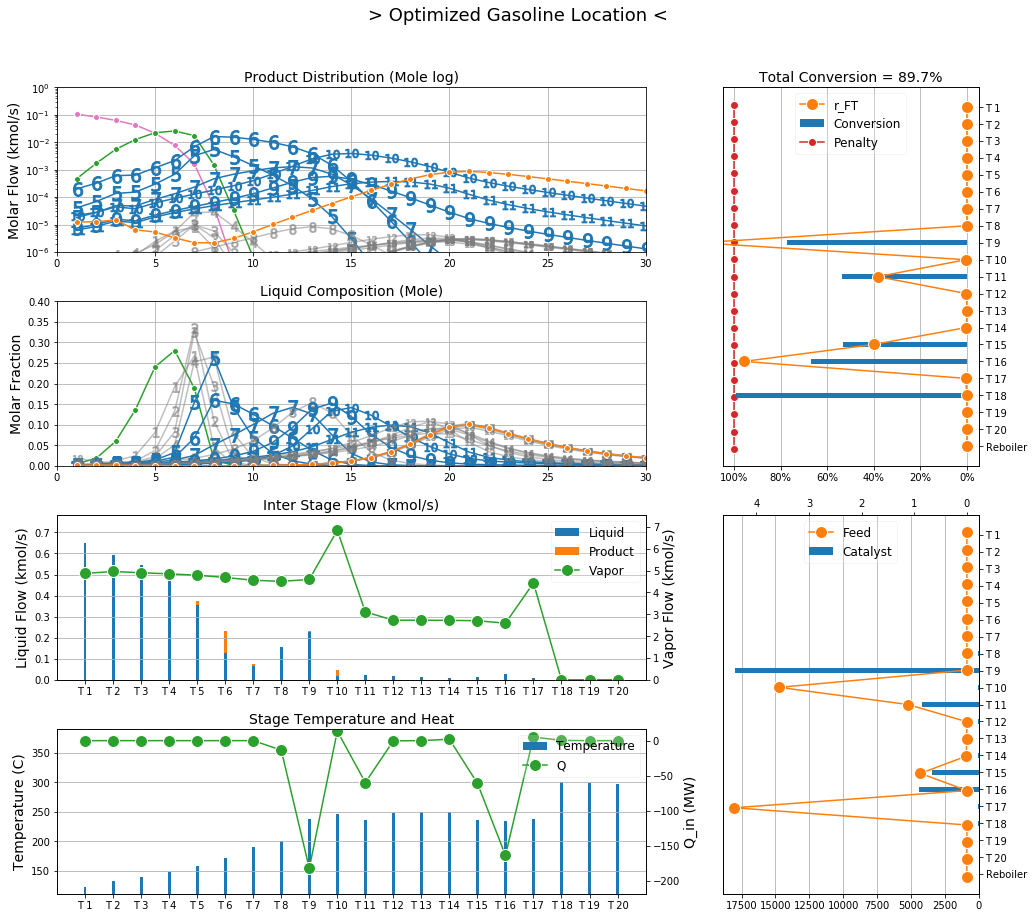

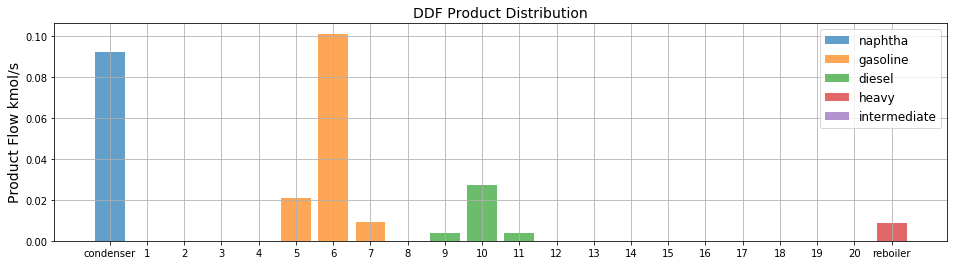

In [35]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Gasoline Location')
plot_product_distribution(model,pdf)

In [36]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(13)
model.N_tray['diesel'].setub(20)

In [37]:
while True:
    iter_count += 2
    total_iter += 2
    opt = add_solver(pe, max_iter = iter_count, warm_start = True, output = True)
    model_tmp = deepcopy(model)
    results = opt.solve(model_tmp,tee=False)

    for i in meta_results.keys():
        if i != 'iter_count' and i != 'total_iter':
            meta_results[i].append(model.find_component(i).value)
    meta_results['iter_count'].append(iter_count)
    meta_results['total_iter'].append(total_iter)
    
    print('iter_count',iter_count,'total_iter',total_iter,'obj',model_tmp.obj())
    if results.solver.termination_condition.key == 'optimal':
        break
        
iter_count = 0
model = deepcopy(model_tmp)

    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 2 total_iter 468 obj 0.13141698768148513
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 4 total_iter 470 obj 0.13141575950627857
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 6 total_iter 472 obj 0.1314071038023989
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 8 total_iter 474 obj 0.13134563676853508
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 10 total_iter 476 obj 0.13127141282284024
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
  

iter_count 68 total_iter 534 obj 0.13636400521242062
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 70 total_iter 536 obj 0.1362222186862667
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 72 total_iter 538 obj 0.1362603580775244
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 74 total_iter 540 obj 0.13657252472075032
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 76 total_iter 542 obj 0.1364441729512536
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 78 total_iter 544 obj 0.13640919319685174
    model=reactive_distillation;
        message from s

iter_count 136 total_iter 602 obj 0.13388043727892998
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 138 total_iter 604 obj 0.13474316805569606
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 140 total_iter 606 obj 0.133199551295292
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 142 total_iter 608 obj 0.13669580630342207
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 144 total_iter 610 obj 0.13604049340744684
    model=reactive_distillation;
        message from solver=Ipopt 3.12.10\x3a Maximum Number of Iterations
        Exceeded.
iter_count 146 total_iter 612 obj 0.1399870906445486
    model=reactive_distillation;
        message 


> Optimized Diesel Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 90.00%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -149.                                        1.7258          0.6052  0.0819       2.4668

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     122.5  0.000       0.000  0.000  0.000  0.000       4.8799  0.0000  0.6993  0.0000       20.000
NON--[2]     131.0  0.000       0.000  0.000  0.000  0.000       4.9740  0.0000  0.6289  0.0000       20.000
NON--[3]     140.0  0.000       0.000  0.000  0.000  0.000       4.9036  0.0000  0.5578  0.0000       20.000
NON--[4]     150.7  0.000       0.000  0.000  0.00

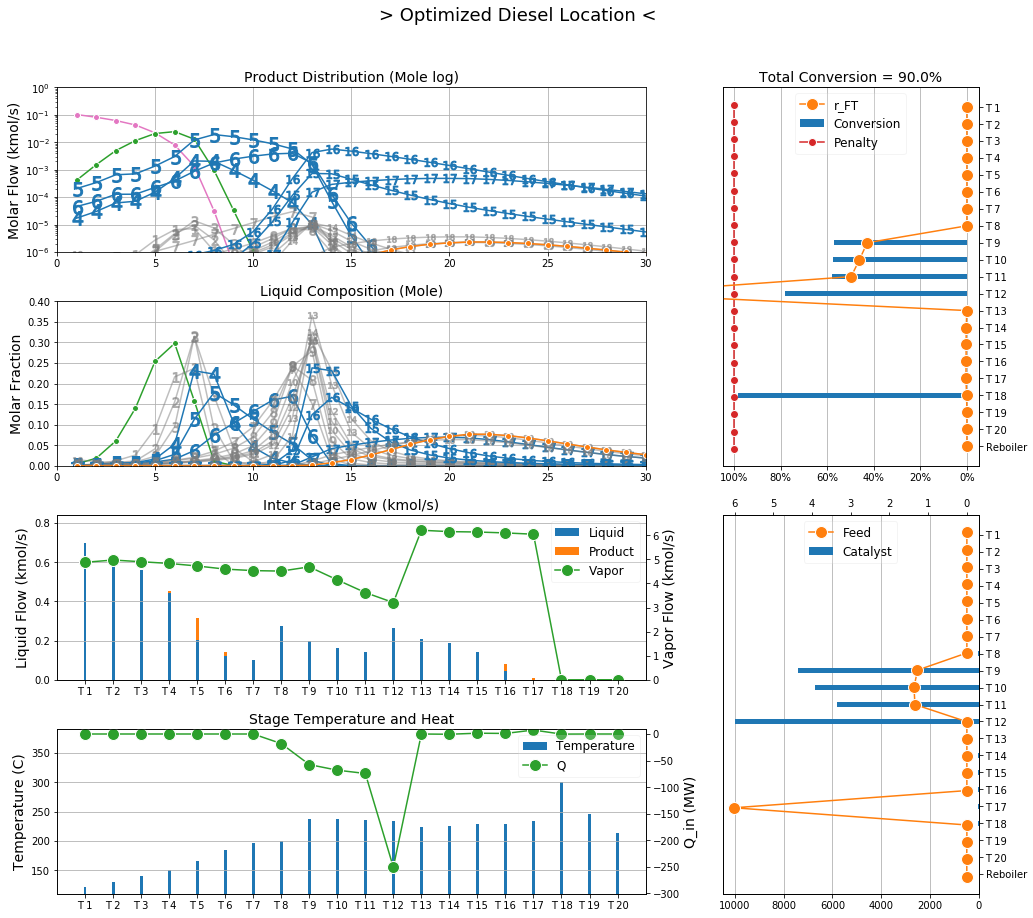

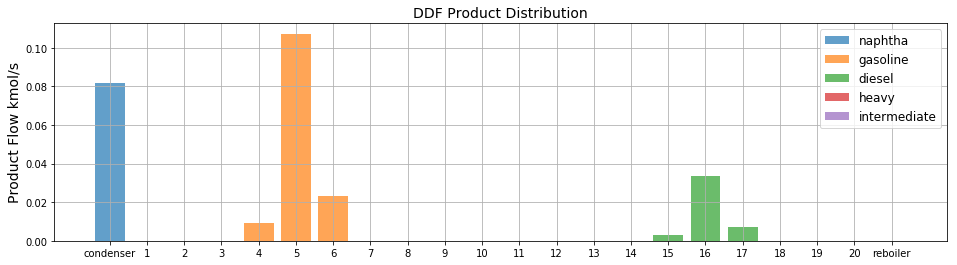

In [38]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

In [39]:
pdf.close()

In [40]:
with open('./log/results/{}.pickle'.format(logname),'wb') as f:
    pickle.dump(meta_results,f,protocol=pickle.HIGHEST_PROTOCOL)